In [64]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

# Joint Ranging and Timing Simulation

Given a single reference node, provided the reference clock, and two-way communication between all nodes, it intends to efficiently estimate all the absolute clock skews $\boldsymbol\omega$, clock offsets $\boldsymbol\phi$, and pairwise distances $\mathbf d$ for all nodes in the network.

## Idea

1. Initialize N nodes
2. Arrange M pairs of nodes each with arbitrary distance
3. Start time t = 0
4. While time t < end time T:
    1. Randomize:
        1. Node i send to node j, or vice versa
    2. If K >= 2:
        1. Optimize for clock skews, clock offsets, and propagation delays
6. Plot

## Notation

- Element-wise Hadamard product $\odot$
- Element-wise Hadamard division $\oslash$
- Element-wise matrix exponent $(\cdot)^{\odot N}$
- Kronecker product $\otimes$
- Transpose operator $(\cdot)^T$
- Vector of ones $\mathbf 1_N=[1,1,\ldots,1]\in\mathbb{R}^{N\times1}$
- $N \times N$ dentity matrix $\mathbf I_N$

## Problem Formulation

Affine clock model of local time at node $i$ diverged from the ideal global time $t$:

$$ t_i = \omega_i t + \phi_i $$

- Clock skew $\omega_i \in \mathbb R_+$
- Clock offset $\phi_i \in \mathbb R$

Clock skew and offset parameters for all $N$ nodes: $\boldsymbol\omega = [\omega_1,\omega_2,\ldots,\omega_N]^T\in\mathbb R_+^{N \times 1}$, and $\boldsymbol\phi = [\phi_1,\phi_2,\ldots,\phi_N]^T\in\mathbb R^{N \times 1}$.

Translation from local time $t_i$ to the global time $t$:

$$\mathcal F_i(t_i)\triangleq t = \alpha_i t_i + \beta_i$$

- Calibration parameters needed to correct the local clock of node $i$: $[\alpha_i, \beta_i] \triangleq [\omega_i^{-1}, -\omega_i^{-1}\phi_i]$.

For all $N$ nodes in the network:

- $\boldsymbol\alpha \triangleq \mathbf 1_N \oslash \boldsymbol \omega \in \mathbb R_+^{N \times 1}$
- $\boldsymbol\beta \triangleq -\boldsymbol\phi \oslash \boldsymbol\omega \in \mathbb R^{N\times 1}$

All $M=\begin{pmatrix}N\\2\end{pmatrix}$ unique pairwise distances between $N$ nodes are given by $\mathbf d = [d_{11},d_{12},\ldots,d_{(N-1)(N)}]\in\mathbb R^{M\times1}$

The propagation delay between nodes $\boldsymbol\tau = \mathbf dc^{-1}\in\mathbb R^{M \times 1}$

- Speed of light in the medium $c$

In [2]:
# Constants
c = 3.0e8   # Speed of light in vacuum

In [3]:
class Message:
    def __init__(self, node_idx: int, t_Tx: float) -> None:
        """
        Initialize a Message with:
        - node_idx: which node did this message belong to
        - t_Tx: the time this message is sent
        """
        self.node_idx = node_idx
        self.t_Tx = t_Tx
        self.t_Rx = -1

    def receive(self, t_Rx) -> None:
        """
        - t_Rx: the time this message is received
        """
        self.t_Rx = t_Rx

In [ ]:
class Node:
    
    def __init__(self, node_id: int, x: float, y: float, clock_skew: float, clock_offset) -> None:
        """
        Initialize a Node with:
        - clock_skew: multiplicative factor to adjust global time in R+
        - clock_offset: additive offset to adjust global time in R
        - t: local time of the node
        - connected_nodes: list of other nodes connected to this one
        """
        self.node_id = node_id
        self.x = x
        self.y = y
        self.clock_skew = np.abs(clock_skew)
        self.clock_offset = clock_offset
        self.t = 0.0
        self.connected_nodes = []
        self.distances = []
        self.t = 0.0

        self.Tx_mailbox = []
        self.Rx_mailbox = []

    def __call__(self, *args, **kwds):
        print(f'Node {self.node_id}')

    def __str__(self):
        return f'Node {self.node_id}'

    def connect_node(self, other: 'Node') -> None:
        """
        Connect this node to another node bidirectionally.
        Ensures that both nodes recognize each other as connected.
        Prevents duplicate connections.
        """
        if other is self:
            # Prevent a node from connecting to itself
            return
        
        if other not in self.connected_nodes:
            self.connected_nodes.append(other)
        if self not in other.connected_nodes:
            other.connected_nodes.append(self)

    def update(self, t_global: float) -> None:
        """
        Update the local time `t` based on the given global time `t_global`,
        using the node's clock skew and offset:
            t = clock_skew * t_global + clock_offset
        """
        self.t = self.clock_skew * t_global + self.clock_offset

    def broadcast(self) -> None:
        """
        Send a message to all connected nodes.
        """
        message = Message(self.idx, self.t)
        self.Tx_mailbox.append(message)
        for other in self.connected_nodes:
            other.receive(message)

    def send(self, node: 'Node') -> None:
        """
        Send a message to a node.
        """
        message = Message(self.idx, self.t)
        self.Tx_mailbox.append(message)
        node.receive(message)

    def receive(self, message: Message) -> None:
        """
        Receive a message from another node.
        """
        message.receive(self.t)
        self.Rx_mailbox.append(message)

    def clear_mailboxes(self) -> None:
        """
        Empty the mailboxes.
        """
        self.Tx_mailbox.clear()
        self.Rx_mailbox.clear()

In [91]:
# Functions
def randomly_connect(nodes: list) -> None:
    """
    Create random connections for every node. Each node must have at least one other connection.
    """
    for node in nodes:
        connected = False
        for other in nodes:
            if node is not other and np.random.randint(0, 2):
                node.connect_node(other)
                connected = True
        if not connected:
            # Pick one random other node to connect if none were chosen
            other = np.random.choice([n for n in nodes if n is not node])
            node.connect_node(other)

def display_nodes(nodes: list, save=False) -> None:
    """
    Plot nodes positions as vertices and their connections as edges, as an image.
    """
    TEXT_OFFSET_X = 50
    TEXT_OFFSET_Y = 50
    plt.figure()
    for node in nodes:
        plt.scatter(x=node.x, y=node.y, s=25, c='k')
        plt.text(x=node.x + TEXT_OFFSET_X, y=node.y + TEXT_OFFSET_Y, s=str(node.node_id))
        for other in node.connected_nodes:
            plt.plot([node.x, other.x], [node.y, other.y], linewidth=0.25, linestyle='-', color='gray')
    plt.show()        

def calculate_alphas(clock_skews: np.ndarray) -> np.ndarray:
    """ Calculate an array of calibration parameter alphas given the clock skews of all nodes.

    Inputs:
    - clock_skews: np.array in (N x 1)

    Outputs:
    - alphas: np.array in (N x 1)
    """
    return np.ones(clock_skews.shape) / clock_skews

def calculate_betas(clock_skews: np.ndarray, clock_offsets: np.ndarray) -> np.ndarray:
    """ Calculate an array of calibration parameter betas given the clock skews and clock offsets of all nodes.
    
    Inputs:
    - clock_skews: np.array in (N x 1)
    - clock_offsets: np.array in (N x 1)

    Outputs:
    - betas: np.array in (N x 1)
    """
    return -clock_offsets / clock_skews

def calculate_propagation_delay(distances: np.ndarray) -> np.ndarray:
    """ Calculate an array of propagation delays of all nodes given the distances in vacuum.

    Inputs:
    - distances: np.array in (M x 1)

    Outputs:
    - propagation_delay: np.array in (M x 1)
    """
    return distances / c


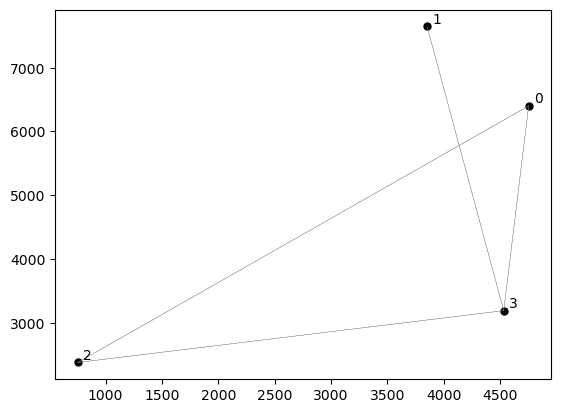

In [93]:
N = 4
nodes = [Node(i, x=np.random.uniform(low=0, high=10e3), y=np.random.uniform(low=0, high=10000), clock_skew=0.0, clock_offset=0.0) for i in range(N)]
randomly_connect(nodes)
display_nodes(nodes=nodes)

## Pairwise Synchronization and Distance Estimation

Consider the classical two-way communication between a node pair $(i,j)$. Node $i$ initiates the communication and up-links a message to node $j$ and node $j$ responds by downlinking a message back to node $i$. The two nodes communicate messages back and forth, and the transmission and reception times are recorded independently at the respective nodes. $T_{ij}^{(k)}$ denotes the local time recorded at node $i$ for the $k$-th message departing to node $j$ and $R_{ji}^{(k)}$ is the corresponding local time marker recorded by the node $j$ on receiving the message from node $i$.

There are $K$ two-way communications between the pair, node $i$ and node $j$, during which assuming that the propagation delay between the two nodes $\tau_{ij}=d_{ij}/c\equiv d_{ji}/c$ is fixed.

The transmission and reception markers:

$$ T_{ij}^{(k)} + q_1^((k)) = \omega_i(\mathcal F_j (R_{ji}^{(k)} + q_2^{(k)}) - \tau_{ij}) + \phi_i$$
$$ R_{ij}^{(k)} + q_3^{(k)} = \omega_i(\mathcal F_j (T_{ji}^{(k)} + q_4^{(k)}) - \tau_{ij}) + \phi_i$$

- Gaussian I.I.D. noise variables $\{q_1^{k}, q_2^{k}, q_3^{k}, q_4^{k}\}\sim\mathcal N(0, 0.5\sigma^2)$

Rearranging the terms:

$$\alpha_i T_{ij}^{(k)} = \alpha_j R_{ji}^{(k)} - \beta_i + \beta_j - \tau_{ij} - \alpha_i q_1^{(k)} + \alpha_j q_2^{(k)}$$
$$\alpha_i R_{ij}^{(k)} = \alpha_j T_{ji}^{(k)} - \beta_i + \beta_j + \tau_{ij} - \alpha_i q_3^{(k)} + \alpha_j q_4^{(k)}$$

For all $K$ two-way communications, a generalized model for a pair of nodes:

$$\begin{bmatrix}\mathbf t_{ji} & -\mathbf t_{ij} & \mathbf 1_{2K} & -\mathbf 1_{2K} & \mathbf e\end{bmatrix}\begin{bmatrix}\alpha_j \\ \alpha_i \\ \beta_j \\ \beta_i \\ \tau_{ij}\end{bmatrix} = \mathbf q_{ij} (1) $$

$\mathbf t_{ij},\mathbf t_{ji}\in\mathbb R^{2K \times 1}$ are time markers recorded at node $i$ and node $j$, respectively while communicating with each other:

$$\mathbf t_{ij} = [T_{ij}^{(1)}, R_{ij}^{(1)}, T_{ij}^{(2)}, \ldots, R_{ij}^{(K)}]^T$$
$$\mathbf t_{ji} = [R_{ji}^{(1)}, T_{ji}^{(1)}, R_{ji}^{(2)}, \ldots, T_{ji}^{(K)}]^T$$

$\mathbf e = [-1,+1,\ldots,+1]^T\in\mathbb R^{2K+1}$

$\mathbf q_{ij}$ is I.I.D. noise vector, modelled as $\mathbf q_{ij}\sim\mathcal N(0, 0.5\sigma^2(\beta_i^2+\beta_j^2))\in\mathbb R^{2K+1}$

Clock skews $\omega_i,\omega_j$ are very close to 1 and the errors are of the order of $10^{-4}$. Hence the noise vector could be approximated by $\mathbf q_{ij}\sim\mathcal N(0,\sigma^2)\in\mathbb R^{2K\times 1}$

Asserting node $i$ as the reference node with $[\alpha_i,\beta_i]=[1,0]$, Equation (1) is simplified to:

$$\mathbf A_{ij}\theta_j = \mathbf t_{ij} + \mathbf q_{ij} (2)$$

- $\mathbf A = [\mathbf t_{ji}, \mathbf 1_{2K}, \mathbf e]\in\mathcal R^{2K\times3}$
- $\boldsymbol \theta_j = [\beta_j, \alpha_j, \tau_{ij}]^T\in\mathcal R^{3\times1}$

The Pairwise Least Squares (PLS) solution for estimating the clock skew ($\omega_j\triangleq 1/\alpha_j$), the clock offset ($\phi_j\triangleq -\beta_j/\alpha_j$) of node j and its distance ($d_{ij}\triangleq c\tau_{ij}$) is obtained by minimizing the least squares norms, i.e.

$$\hat{\boldsymbol\theta}_j = \underset{\boldsymbol\theta_j}{\arg\min}\;\|\mathbf A_{ji}\boldsymbol\theta_j-\mathbf t_{ij}\|_2^2=(\mathbf A_{ji}^T\mathbf A_{ji})^{-1}\mathbf A_{ji}^T\mathbf t_{ij}$$

**NOTE:** In two-way communication model, there is no assumption that the messages have to be alternating regularly. Hence the measured timestamps are valid as long as the distance between the nodes and the clock parameters are stable within reasonable limits during the estimation process.

**NOTE:** If the two-way link is replaced with one-way communication then matrix $\bar{\mathbf A}_{ji}$ is rank deficient and hence there is no optimal solution to jointly estiamte the clock parameters and pairwise distances.

In [31]:
# Constants
noise_variance = 10e-4

In [32]:
def generate_pairwise_noise_vector(K: int) -> np.ndarray:
    """ Generate a noise matrix corresponding to a node pair (i,j) given the number of two-way communications.

    Inputs: 
    - K: int

    Outputs:
    - q_ij: np.ndarray in (2K x 1)
    """
    return np.random.normal(0, noise_variance, size=(2*K, 1))

def generate_e(K: int) -> np.ndarray:
    """ Generate the e vector with alternating -1 and 1 values.

    Inputs:
    - K: int

    Outputs:
    - e: np.ndarray in (2K x 1)
    """
    return np.array([(-1)**i for i in range(2*K)]).reshape(-1, 1)

## Network Synchronization and Ranging

Extend the pairwise model to the entire network and find a global optimal solution for all unknown clock parameters and pairwise distance using a single reference.

Without loss of generality, assume that node 1 is the reference node in the wireless network and that all links are present. Rearranging the terms, for all $\{i, j\}$:

$$\begin{bmatrix}\mathbf T & \mathbf E_1 & \mathbf E_2\end{bmatrix}\begin{bmatrix}\boldsymbol\alpha \\ \boldsymbol\beta \\ \boldsymbol\tau\end{bmatrix} = \mathbf q$$

- $\mathbf T\in\mathbb R^{2KM\times N}$ contains all the timing vectors from all $N$ nodes
- $\mathbf E_1\in\mathbb R^{2KM\times N}$ 
- $\mathbf E_2=-\mathbf I_M\otimes\mathbf e\in\mathbb R^{2KM\times M}$

For $N=4$, $\mathbf T$ and $\mathbf E_1$:

$$\mathbf T=\begin{bmatrix}\mathbf t_{12}&-\mathbf t_{21}&&\\\mathbf t_{13}&&-\mathbf t_{31}&\\\mathbf t_{14}&&&-\mathbf t_{41}\\&\mathbf t_{23}&-\mathbf t_{32}&\\&\mathbf t_{24}&&-\mathbf t_{42}\\&&\mathbf t_{34}&-\mathbf t_{43}\end{bmatrix}$$

$$\mathbf E_1=\begin{bmatrix}+\mathbf 1_{2K}&-\mathbf 1_{2K}&&\\+\mathbf 1_{2K}&&-\mathbf 1_{2K}&\\+\mathbf 1_{2K} &&& -\mathbf 1_{2K}\\&+\mathbf 1_{2K}&-\mathbf 1_{2K}&\\&+\mathbf 1_{2K}&&-\mathbf 1_{2K}\\&&+\mathbf 1_{2K}&-\mathbf 1_{2K}\end{bmatrix}$$

The global noise vector is $\mathbf q=[\mathbf q_{12},\mathbf q_{13},\ldots,\mathbf q_{(N-1)(N)}]\in\mathbb R^{2KM\times1}$

Since node 1 is the reference node, i.e. $[\alpha_1,\beta_1]=[1,0]$, rearranging the terms:

$$\bar{\mathbf A}\boldsymbol\theta = -\bar{\mathbf t}_1+\mathbf q$$

- $\bar{\mathbf A}=\begin{bmatrix}\bar{\mathbf T}&\bar{\mathbf E_1}&\mathbf E_2\end{bmatrix}\in\mathbb R^{2KM\times L}$
- $\boldsymbol\theta = \begin{bmatrix}\bar{\boldsymbol\alpha}&\bar{\boldsymbol\beta}&\boldsymbol\tau\end{bmatrix}\in\mathbb R^{L\times 1}$
- $L = 2N+M-2$
- $\bar{\mathbf E}_1\in\mathbb R^{2KM\times(N-1)}$
- $\bar{\boldsymbol\alpha},\bar{\boldsymbol\beta}\in\mathbb R^{(N-1)\times1}$ represents the unknown clock parameters of all the nodes excluding node 1.

$\bar{\mathbf t_1}\in\mathbb R^{2KM\times1}$ is the first column of matrix $\mathbf T$ containing the time markers recorded at node 1, whilst communicating with the other nodes in the network.

**NOTE:** Analyzing the components of matrix $\bar{\mathbf A}$, both $\bar{\mathbf T},\bar{\mathbf E_1}$ are full rank, since the respective first $2K(N-1)$ rows are formed by block diagonal matrices. Note that all columns of $\mathbf E_2$ are also independent.

If $K\ge2$, then a Global Least Squares (GLS) solution is feasible and is obtained by minimizng the least squares norm. The unknown clock skews ($\bar{\boldsymbol\omega}\triangleq\mathbf 1_N\oslash\bar{\boldsymbol\alpha}$), the unknown clock offsets ($\bar{\boldsymbol\phi}\triangleq-\bar{\boldsymbol\beta}\oslash\bar{\boldsymbol\alpha}$) of the nodes, and the pairwise distances ($\mathbf d\triangleq\boldsymbol\tau c$) in the network can be solved using:

$$\hat{\boldsymbol\theta} = \underset{\boldsymbol\theta}{\arg\min}\;\|\bar{\mathbf A}\boldsymbol\theta+\bar{\mathbf t_1}\|_2^2=(\bar{\mathbf A}^T\bar{\mathbf A})^{-1}\bar{\mathbf A}^T\bar{\mathbf t}_1$$

**NOTE:** In general, if some pairwise communications are missing then corresponding rows in matrix $\bar{\mathbf A}$ are dropped. Consequentially, the pairwise distances between those particular network wide synchronization is still feasible, if and only if $\bar{\mathbf A}$ is full rank. *In other words, every node has at least single two-way communication link with any other node in the network.*

In [ ]:
def generate_global_noise_vector(K: int, M: int) -> np.ndarray:
    """ Generate the global noise vector for all node pairs
    
    Inputs:
    - K: number of two-way communications
    - M: number of node pairs
    
    Outputs:
    - q: np.array in (2*K*M x 1)
    """
    return np.vstack([generate_pairwise_noise_vector(K) for _ in range(M)])

## Simulation

In [ ]:
# Constants
MAX_CLOCK_SKEW = 1.0
MIN_CLOCK_OFFSET = -1.0
MAX_CLOCK_OFFSET = 1.0

MIN_DISTANCE = 0.0
MAX_DISTANCE = 10e3

# Parameters
N = 4       # Number of nodes
dt = 1e-3   # Discrete timestep for simulation
T = 5.0     # Max simulation time duration

nodes = [Node(np.random.uniform(0,MAX_CLOCK_SKEW), np.random.uniform(MIN_CLOCK_OFFSET, MAX_CLOCK_OFFSET)) for _ in range(N)]


t = 0.0


In [51]:
while t < T:

    # Nodes update
    for node in nodes:
        node.update(t)

    # Loop update
    t += dt